The original method of extracting the data had missing sent messages. In order to grab  all messages a local iPhone backup was created. The backup is located at "~/Library/Application Support/MobileSync/Backup/". The number of folders here is dependant on how many different phones have been backed up. Inside this folder should be a folder "3d". "3d0d7e5fb2ce288813306e4d4636395e047a3d28" is the necessary file. 

A DB Browser is needed to look at the information about the database. The handle_id is needed to isolate the messages by person.

Open Terminal and type-
"sqlite3 (location of necessary file)"
 
Here is a full example-
"sqlite3 /Users/greg/Library/Application\ Support/MobileSync/Backup/0f4c9d00a4313418210fee5026491e2a628b8f5b/3d/3d0d7e5fb2ce288813306e4d4636395e047a3d28"

Access to the file should be granted. In order to export the messages to a csv file, type the following commands-

.mode csv
.output data.csv
select datetime(message.date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime"), is_from_me, text from message where handle_id=0;

"data.csv" is the name that the file will be saved as.
datetime(message.date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime") is necessary to grab the dates from each individual text.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import brown
from collections import Counter

In [2]:
df = pd.read_csv('/Users/greg/Dropbox/Projects/Machine Learning/data.csv', encoding='utf8')
df.head(5)

,datetime,is_from_me,text
0,2/8/18 22:41,0,Anagrams
1,2/8/18 22:42,0,I've scored 1900 points
2,2/8/18 22:42,1,�￼
3,2/8/18 22:44,0,Aw wtf
4,2/8/18 22:44,0,I had major brain fart


In [3]:
# DATA WRANGLING
# CONVERTING DATE TO DATETIME
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
# df['datetime'] = df['datetime'].astype('datetime64[ns]')

# WORD COUNT
df['word_count'] = df['text'].str.split().str.len()

# CHECKS IF TEXT WAS A LINK
df['link'] = df['text'].str.contains('http')

# CHECKS IF TEXT CONTAINS GIF/IMAGE
df['media'] = df['text'].str.contains('�')

# GRABBING WEEKDAY, DATE, AND TIME FROM DATETIME
df['weekday'] = df['datetime'].dt.weekday
df['week'] = df['datetime'].dt.week
df['date'] = df['datetime'].dt.date
df['time'] = df['datetime'].dt.time
df['hour'] = df['datetime'].dt.hour
df['text'] = df['text'].str.lower()

df.dropna(inplace=True)

df.head()

,datetime,is_from_me,text,word_count,link,media,weekday,week,date,time,hour
0,2018-02-08 22:41:00+00:00,0,anagrams,1.0,False,False,3,6,2018-02-08,22:41:00+00:00,22
1,2018-02-08 22:42:00+00:00,0,i've scored 1900 points,4.0,False,False,3,6,2018-02-08,22:42:00+00:00,22
2,2018-02-08 22:42:00+00:00,1,�￼,1.0,False,True,3,6,2018-02-08,22:42:00+00:00,22
3,2018-02-08 22:44:00+00:00,0,aw wtf,2.0,False,False,3,6,2018-02-08,22:44:00+00:00,22
4,2018-02-08 22:44:00+00:00,0,i had major brain fart,5.0,False,False,3,6,2018-02-08,22:44:00+00:00,22


In [4]:
# df.to_csv('groupedby_data.csv', encoding='utf-8', index=False)

# CREATES MULTI-INDEX THAT ALLOWS MESSAGES TO BE GROUPED BY DATE
df.set_index(['date', 'time'], drop=False, inplace=True)

# DROPS THE COLUMNS 'DATE' AND 'TIME' BECAUSE THEY ARE BEING USED AS A MULTI-INDEX
# df.drop(['date', 'time'],axis=1, inplace=True)

df.head()

datetime  is_from_me  \
date       time                                                   
2018-02-08 22:41:00+00:00 2018-02-08 22:41:00+00:00           0   
           22:42:00+00:00 2018-02-08 22:42:00+00:00           0   
           22:42:00+00:00 2018-02-08 22:42:00+00:00           1   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   

                                              text  word_count   link  media  \
date       time                                                                
2018-02-08 22:41:00+00:00                 anagrams         1.0  False  False   
           22:42:00+00:00  i've scored 1900 points         4.0  False  False   
           22:42:00+00:00                       �￼         1.0  False   True   
           22:44:00+00:00                   aw wtf         2.0  False  False   
           22:44:00+00:00  i had major brain fart          5.0  False  False   

                           weekday  week        date            time  hour  
date       time                                                             
2018-02-08 22:41:00+00:00        3     6  2018-02-08  22:41:00+00:00    22  
           22:42:00+00:00        3     6  2018-02-08  22:42:00+00:00    22  
           22:42:00+00:00        3     6  2018-02-08  22:42:00+00:00    22  
           22:44:00+00:00        3     6  2018-02-08  22:44:00+00:00    22  
           22:44:00+00:00        3     6  2018-02-08  22:44:00+00:00    22

In [5]:
# CREATES AN ARRAY OF ALL THE DATES THAT MESSAGES WERE SENT
days = df['date'].unique()
days

array([datetime.date(2018, 2, 8), datetime.date(2018, 2, 9),
       datetime.date(2018, 2, 10), datetime.date(2018, 2, 12),
       datetime.date(2018, 2, 13), datetime.date(2018, 2, 14),
       datetime.date(2018, 2, 15), datetime.date(2018, 2, 16),
       datetime.date(2018, 2, 17), datetime.date(2018, 2, 18),
       datetime.date(2018, 2, 19), datetime.date(2018, 2, 20),
       datetime.date(2018, 2, 21), datetime.date(2018, 2, 22),
       datetime.date(2018, 2, 23), datetime.date(2018, 2, 24),
       datetime.date(2018, 2, 25), datetime.date(2018, 2, 26),
       datetime.date(2018, 2, 27), datetime.date(2018, 2, 28),
       datetime.date(2018, 3, 1), datetime.date(2018, 3, 2),
       datetime.date(2018, 3, 3), datetime.date(2018, 3, 4),
       datetime.date(2018, 3, 5), datetime.date(2018, 3, 6),
       datetime.date(2018, 3, 7), datetime.date(2018, 3, 8),
       datetime.date(2018, 3, 9), datetime.date(2018, 3, 10),
       datetime.date(2018, 3, 11), datetime.date(2018, 3, 12),
   

In [6]:
# RETURNS THE NUMBER OF UNIQUE DAYS
df['date'].nunique()
# n_days

255

In [7]:
# RETURNS THE START DATE
df['date'].min()

datetime.date(2018, 2, 8)

In [8]:
# RETURNS THE LAST DATE
df['date'].max()

datetime.date(2018, 10, 22)

In [9]:
# CREATES AN ARRAY FOR AMOUNT OF TOTAL AMOUNT OF MESSAGES SENT BETWEEN TWO PEOPLE ON ONE DAY
n_texts = {}
for d in days:
    n_texts[d] = len(df.loc[d])

np.asarray(list(n_texts.values()))

array([  70,  273,   96,  105,  632,  629,  103,  322, 1128,  175,  709,
        628,  395,  728,  468,  427,  162,  366,  433,  314,   64,  641,
        603,  869,  298,  453,  522,  560,  642,  911,  462,  342,  507,
        631,  246,  450,  312,  269,  469,  584,  329,  679,  464,  420,
        334,  447,  405,  611,  338,  511,  348,  279,  445,  429,  337,
        407,  398,  225,  356,  187,  524,  189,  299,  169,  875,  473,
        293,  992,  471,  556,  363,  179,  537,  430,  499,  202,  300,
        290,  466,  379,  448,  243,  327,  248,  366,  579,  302,  330,
        197,  152,  160,  223,  346,  475,  266,  257,  495,  293,  251,
        331,   14,  163,  272,  143,  187,  167,  196,  234,  182,  434,
        185,   97,  296,  278,  208,  200,  363,  235,  239,  311,  301,
        267,  195,  444,  352,  221,  205,  537,  280,  461,  454,  448,
        601,  221,  499,  399,  427,  484,  245,  107,  208,  417,  503,
        263,  137,  306,  356,  306,  197,   86,  1

In [10]:
# CREATES A NEW DATAFRAME FOR TEXTS THAT WERE SENT FROM THE USER
sent = df[df['is_from_me']==1]
sent.head()

datetime  is_from_me  \
date       time                                                   
2018-02-08 22:42:00+00:00 2018-02-08 22:42:00+00:00           1   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           1   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           1   
           22:46:00+00:00 2018-02-08 22:46:00+00:00           1   
           22:50:00+00:00 2018-02-08 22:50:00+00:00           1   

                                                       text  word_count  \
date       time                                                           
2018-02-08 22:42:00+00:00                                �￼         1.0   
           22:44:00+00:00                              lmao         1.0   
           22:44:00+00:00  you thought it was gonna be easy         7.0   
           22:46:00+00:00                          anagrams         1.0   
           22:50:00+00:00                                �￼         1.0   

                            link  media  weekday  week        date  \
date       time                                                      
2018-02-08 22:42:00+00:00  False   True        3     6  2018-02-08   
           22:44:00+00:00  False  False        3     6  2018-02-08   
           22:44:00+00:00  False  False        3     6  2018-02-08   
           22:46:00+00:00  False  False        3     6  2018-02-08   
           22:50:00+00:00  False   True        3     6  2018-02-08   

                                     time  hour  
date       time                                  
2018-02-08 22:42:00+00:00  22:42:00+00:00    22  
           22:44:00+00:00  22:44:00+00:00    22  
           22:44:00+00:00  22:44:00+00:00    22  
           22:46:00+00:00  22:46:00+00:00    22  
           22:50:00+00:00  22:50:00+00:00    22

In [11]:
# CREATES A NEW DATAFRAME FOR TEXTS THAT WERE RECEIVED BY THE USER
received = df[df['is_from_me']==0]
received.head()

datetime  is_from_me  \
date       time                                                   
2018-02-08 22:41:00+00:00 2018-02-08 22:41:00+00:00           0   
           22:42:00+00:00 2018-02-08 22:42:00+00:00           0   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   

                                                        text  word_count  \
date       time                                                            
2018-02-08 22:41:00+00:00                           anagrams         1.0   
           22:42:00+00:00            i've scored 1900 points         4.0   
           22:44:00+00:00                             aw wtf         2.0   
           22:44:00+00:00            i had major brain fart          5.0   
           22:44:00+00:00  that wasn't even a fart actually          6.0   

                            link  media  weekday  week        date  \
date       time                                                      
2018-02-08 22:41:00+00:00  False  False        3     6  2018-02-08   
           22:42:00+00:00  False  False        3     6  2018-02-08   
           22:44:00+00:00  False  False        3     6  2018-02-08   
           22:44:00+00:00  False  False        3     6  2018-02-08   
           22:44:00+00:00  False  False        3     6  2018-02-08   

                                     time  hour  
date       time                                  
2018-02-08 22:41:00+00:00  22:41:00+00:00    22  
           22:42:00+00:00  22:42:00+00:00    22  
           22:44:00+00:00  22:44:00+00:00    22  
           22:44:00+00:00  22:44:00+00:00    22  
           22:44:00+00:00  22:44:00+00:00    22

In [12]:
# CREATES A DICTIONARY WITH DATES AS THE KEYS AND MESSAGES SENT AS THE VALUE
def count_texts(df, days):
    texts = {}
    for d in days: 
        if d in df['date']:
            texts[d] = len(df.loc[d])
        else:
            texts[d] = 0
            
    return texts

In [34]:
sent_texts = count_texts(sent, days)
sent_texts

{datetime.date(2018, 2, 8): 32,
 datetime.date(2018, 2, 9): 131,
 datetime.date(2018, 2, 10): 50,
 datetime.date(2018, 2, 12): 46,
 datetime.date(2018, 2, 13): 317,
 datetime.date(2018, 2, 14): 329,
 datetime.date(2018, 2, 15): 53,
 datetime.date(2018, 2, 16): 171,
 datetime.date(2018, 2, 17): 599,
 datetime.date(2018, 2, 18): 99,
 datetime.date(2018, 2, 19): 368,
 datetime.date(2018, 2, 20): 338,
 datetime.date(2018, 2, 21): 205,
 datetime.date(2018, 2, 22): 382,
 datetime.date(2018, 2, 23): 246,
 datetime.date(2018, 2, 24): 228,
 datetime.date(2018, 2, 25): 84,
 datetime.date(2018, 2, 26): 201,
 datetime.date(2018, 2, 27): 224,
 datetime.date(2018, 2, 28): 170,
 datetime.date(2018, 3, 1): 35,
 datetime.date(2018, 3, 2): 339,
 datetime.date(2018, 3, 3): 307,
 datetime.date(2018, 3, 4): 442,
 datetime.date(2018, 3, 5): 162,
 datetime.date(2018, 3, 6): 215,
 datetime.date(2018, 3, 7): 280,
 datetime.date(2018, 3, 8): 321,
 datetime.date(2018, 3, 9): 316,
 datetime.date(2018, 3, 10): 476

In [35]:
received_texts = count_texts(received, days)
received_texts

{datetime.date(2018, 2, 8): 38,
 datetime.date(2018, 2, 9): 142,
 datetime.date(2018, 2, 10): 46,
 datetime.date(2018, 2, 12): 59,
 datetime.date(2018, 2, 13): 315,
 datetime.date(2018, 2, 14): 300,
 datetime.date(2018, 2, 15): 50,
 datetime.date(2018, 2, 16): 151,
 datetime.date(2018, 2, 17): 529,
 datetime.date(2018, 2, 18): 76,
 datetime.date(2018, 2, 19): 341,
 datetime.date(2018, 2, 20): 290,
 datetime.date(2018, 2, 21): 190,
 datetime.date(2018, 2, 22): 346,
 datetime.date(2018, 2, 23): 222,
 datetime.date(2018, 2, 24): 199,
 datetime.date(2018, 2, 25): 78,
 datetime.date(2018, 2, 26): 165,
 datetime.date(2018, 2, 27): 209,
 datetime.date(2018, 2, 28): 144,
 datetime.date(2018, 3, 1): 29,
 datetime.date(2018, 3, 2): 302,
 datetime.date(2018, 3, 3): 296,
 datetime.date(2018, 3, 4): 427,
 datetime.date(2018, 3, 5): 136,
 datetime.date(2018, 3, 6): 238,
 datetime.date(2018, 3, 7): 242,
 datetime.date(2018, 3, 8): 239,
 datetime.date(2018, 3, 9): 326,
 datetime.date(2018, 3, 10): 435

In [36]:
# CREATES A DICTIONARY THAT HOLDS THE DAYS FOR THE MOST AND MINIMUM AMOUNT OF TEXTS SENT AND THE NUMBER OF TEXTS
def min_max_text(df):
    """
    """
    max_texts = max(df.values())
    min_texts = min(df.values())
    max_text_day = [k for k, v in df.items() if v == max_texts]
    min_text_day = [k for k, v in df.items() if v == min_texts]
    
    return {min_text_day[0]: min_texts, max_text_day[0]: max_texts}

In [37]:
sent_mmt = min_max_text(sent_texts)
sent_mmt

{datetime.date(2018, 5, 21): 0, datetime.date(2018, 9, 3): 732}

In [38]:
received_mmt = min_max_text(received_texts)
received_mmt

{datetime.date(2018, 8, 3): 3, datetime.date(2018, 9, 3): 566}

In [39]:
sent['word_count'].max()

194.0

In [40]:
def largest_text(df):
    return df[df['word_count'] == df['word_count'].max()]['text'].values

In [41]:
sent_largest = largest_text(sent)
sent_largest

array(['\n\n\n×\n\nallnewsshoppingvideosimagesmapsbooksflightspersonalsearch tools\nshowing results for definition blessed\nsearch instead for definitipn blessed\ndictionary\nenter a word, e.g. "pie"\nbless·ed\nblest,ˈblesid/submit\nadjective\nadjective: blessed\n1.\nmade holy; consecrated.\na title preceding the name of a dead person considered to have led a holy life, especially a person formally beatified by the roman catholic church.\n"the convent of the blessed agnes"\nsynonyms:\tholy, sacred, hallowed, consecrated, sanctified; more\nordained, canonized, beatified\n"a blessed place"\nantonyms:\tcursed\nused respectfully in reference to a dead person.\n"a gracious lady of blessed memory"\nendowed with divine favor and protection.\n"blessed are the meek"\nsynonyms:\tfavored, fortunate, lucky, privileged, enviable, happy\n"blessed are the meek"\nantonyms:\twretched\nbringing pleasure or relief as a welcome contrast to what one has previously experienced.\n"he half stumbled out of the

In [42]:
received_largest = largest_text(received)
received_largest

array(["so i use \n4 tomatoes (2 for each bag you use) \nless than half an onion \n1 large garlic clove (or two small ones) \n1 spoonful of knorr tomato seasoning \n1 spoonful of knorr chicken seasoning \nand blend all of that with just a bit of water so it blends nicely \nput some water to boil so you can add that to the soup later\nthen put oil on whatever pot you're going to be making the soup on but just enough to cover the bottom and then plus some\nlet that heat up just for a bit (don't let it heat up too much or else the noodles will start to burn easily when you pour them in) and just keep stirring them around until they're bownish and add the sauce \nadd the boiled water (i would say about the blender full of water and then half) the water can also depend on how much soup to noodles you want and i like a lot of soup so i put the whole tea kettle \nthen just try it and add more chicken and tomato seasoning to your liking (i typically add about 2 or 3 spoonful of chicken and the

In [43]:
df['hour'].value_counts().sort_index()
# hour_usage

0     5911
1     2704
2     1473
3      315
4       52
5       40
6       52
7      347
8     2474
9     3912
10    3535
11    3747
12    4066
13    3556
14    3552
15    3936
16    2897
17    3501
18    3863
19    3892
20    4250
21    5953
22    6827
23    6829
Name: hour, dtype: int64

In [44]:
# DOUBLE CHECK THE MATH
def messages_per_hour(df):
    per_hour = {}
    by_hour = df['hour'].value_counts().sort_index()/df['hour'].nunique()
    for i in np.arange(0,24):
        per_hour[i] = by_hour.loc[i]
    
    return per_hour

In [45]:
df_hour = messages_per_hour(df)
df_hour

{0: 246.29166666666666,
 1: 112.66666666666667,
 2: 61.375,
 3: 13.125,
 4: 2.1666666666666665,
 5: 1.6666666666666667,
 6: 2.1666666666666665,
 7: 14.458333333333334,
 8: 103.08333333333333,
 9: 163.0,
 10: 147.29166666666666,
 11: 156.125,
 12: 169.41666666666666,
 13: 148.16666666666666,
 14: 148.0,
 15: 164.0,
 16: 120.70833333333333,
 17: 145.875,
 18: 160.95833333333334,
 19: 162.16666666666666,
 20: 177.08333333333334,
 21: 248.04166666666666,
 22: 284.4583333333333,
 23: 284.5416666666667}

In [46]:
sent_hour = messages_per_hour(sent)
sent_hour

{0: 133.375,
 1: 61.25,
 2: 32.583333333333336,
 3: 6.166666666666667,
 4: 1.5,
 5: 0.9166666666666666,
 6: 0.6666666666666666,
 7: 6.833333333333333,
 8: 53.25,
 9: 87.875,
 10: 79.54166666666667,
 11: 84.29166666666667,
 12: 89.83333333333333,
 13: 76.95833333333333,
 14: 75.875,
 15: 86.66666666666667,
 16: 64.625,
 17: 76.91666666666667,
 18: 84.625,
 19: 84.95833333333333,
 20: 92.58333333333333,
 21: 131.625,
 22: 148.0,
 23: 151.83333333333334}

In [47]:
received_hour = messages_per_hour(received)
received_hour

{0: 112.91666666666667,
 1: 51.416666666666664,
 2: 28.791666666666668,
 3: 6.958333333333333,
 4: 0.6666666666666666,
 5: 0.75,
 6: 1.5,
 7: 7.625,
 8: 49.833333333333336,
 9: 75.125,
 10: 67.75,
 11: 71.83333333333333,
 12: 79.58333333333333,
 13: 71.20833333333333,
 14: 72.125,
 15: 77.33333333333333,
 16: 56.083333333333336,
 17: 68.95833333333333,
 18: 76.33333333333333,
 19: 77.20833333333333,
 20: 84.5,
 21: 116.41666666666667,
 22: 136.45833333333334,
 23: 132.70833333333334}

In [48]:
def messages_per_week(df):
    week = {}
    df['weekday'].value_counts().sort_index()
    by_week = df['weekday'].value_counts().sort_index()/df['weekday'].nunique()
    for i in np.arange(0, 7):
        week[i] = by_week.loc[i] 
    return week

In [49]:
sent_week = messages_per_week(sent)
sent_week

{0: 863.8571428571429,
 1: 850.1428571428571,
 2: 841.8571428571429,
 3: 740.7142857142857,
 4: 803.2857142857143,
 5: 926.1428571428571,
 6: 846.2857142857143}

In [50]:
both_week = messages_per_week(df)
both_week

{0: 1617.857142857143,
 1: 1620.857142857143,
 2: 1586.2857142857142,
 3: 1402.5714285714287,
 4: 1523.2857142857142,
 5: 1756.857142857143,
 6: 1590.0}

In [51]:
received_week = messages_per_week(received)
received_week

{0: 754.0,
 1: 770.7142857142857,
 2: 744.4285714285714,
 3: 661.8571428571429,
 4: 720.0,
 5: 830.7142857142857,
 6: 743.7142857142857}

In [52]:
df.set_index(['week','time'], drop=False, inplace=True)

In [53]:
def range_of_weeks(df):
    return np.arange(df['week'].min(), df['week'].max())

df_week_range = range_of_weeks(df)
df_week_range

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42])

In [54]:
weekly_change = count_texts(df, df_week_range)
weekly_change

{6: 439,
 7: 3094,
 8: 3517,
 9: 3290,
 10: 3848,
 11: 2757,
 12: 3279,
 13: 2939,
 14: 2597,
 15: 2716,
 16: 3391,
 17: 2566,
 18: 2513,
 19: 1883,
 20: 1893,
 21: 1142,
 22: 1706,
 23: 1857,
 24: 2221,
 25: 2964,
 26: 2287,
 27: 2068,
 28: 1219,
 29: 1693,
 30: 1670,
 31: 1122,
 32: 2456,
 33: 1457,
 34: 1096,
 35: 2471,
 36: 2282,
 37: 1119,
 38: 1068,
 39: 1215,
 40: 1598,
 41: 1014,
 42: 1164}

In [55]:
df.set_index(['date', 'time'], drop=False, inplace=True)
df.head()

datetime  is_from_me  \
date       time                                                   
2018-02-08 22:41:00+00:00 2018-02-08 22:41:00+00:00           0   
           22:42:00+00:00 2018-02-08 22:42:00+00:00           0   
           22:42:00+00:00 2018-02-08 22:42:00+00:00           1   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   

                                              text  word_count   link  media  \
date       time                                                                
2018-02-08 22:41:00+00:00                 anagrams         1.0  False  False   
           22:42:00+00:00  i've scored 1900 points         4.0  False  False   
           22:42:00+00:00                       �￼         1.0  False   True   
           22:44:00+00:00                   aw wtf         2.0  False  False   
           22:44:00+00:00  i had major brain fart          5.0  False  False   

                           weekday  week        date            time  hour  
date       time                                                             
2018-02-08 22:41:00+00:00        3     6  2018-02-08  22:41:00+00:00    22  
           22:42:00+00:00        3     6  2018-02-08  22:42:00+00:00    22  
           22:42:00+00:00        3     6  2018-02-08  22:42:00+00:00    22  
           22:44:00+00:00        3     6  2018-02-08  22:44:00+00:00    22  
           22:44:00+00:00        3     6  2018-02-08  22:44:00+00:00    22

In [56]:
# https://stackoverflow.com/questions/46105180/typeerror-expected-string-or-bytes-like-object-with-python-nltk-word-tokenize

def custom_tokenizer(text):
    if not text:
        text = ''
    return nltk.word_tokenize(text)

In [57]:
df['tokens'] = df['text'].apply(custom_tokenizer).apply(nltk.pos_tag)
df.head(5)

datetime  is_from_me  \
date       time                                                   
2018-02-08 22:41:00+00:00 2018-02-08 22:41:00+00:00           0   
           22:42:00+00:00 2018-02-08 22:42:00+00:00           0   
           22:42:00+00:00 2018-02-08 22:42:00+00:00           1   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   
           22:44:00+00:00 2018-02-08 22:44:00+00:00           0   

                                              text  word_count   link  media  \
date       time                                                                
2018-02-08 22:41:00+00:00                 anagrams         1.0  False  False   
           22:42:00+00:00  i've scored 1900 points         4.0  False  False   
           22:42:00+00:00                       �￼         1.0  False   True   
           22:44:00+00:00                   aw wtf         2.0  False  False   
           22:44:00+00:00  i had major brain fart          5.0  False  False   

                           weekday  week        date            time  hour  \
date       time                                                              
2018-02-08 22:41:00+00:00        3     6  2018-02-08  22:41:00+00:00    22   
           22:42:00+00:00        3     6  2018-02-08  22:42:00+00:00    22   
           22:42:00+00:00        3     6  2018-02-08  22:42:00+00:00    22   
           22:44:00+00:00        3     6  2018-02-08  22:44:00+00:00    22   
           22:44:00+00:00        3     6  2018-02-08  22:44:00+00:00    22   

                                                                      tokens  
date       time                                                               
2018-02-08 22:41:00+00:00                                  [(anagrams, NNS)]  
           22:42:00+00:00  [(i, NN), ('ve, VBP), (scored, VBN), (1900, CD...  
           22:42:00+00:00                                         [(�￼, NN)]  
           22:44:00+00:00                              [(aw, NN), (wtf, NN)]  
           22:44:00+00:00  [(i, NN), (had, VBD), (major, JJ), (brain, NN)...

In [58]:
def grab_texts(df):
    return df['text'].str.split().values

In [59]:
sent_text_messages = grab_texts(sent)
received_text_messages = grab_texts(received)

In [60]:
def word_counter(texts):
    word_count = {}
    all_words = []
    for text in texts:
        for word in text:
            if word.casefold() not in word_count:
                word_count[word.casefold()] = 1
            else:
                word_count[word.casefold()] = word_count[word.casefold()] + 1
                
    word_count_ascending = sorted(word_count.items(), key=lambda kv: kv[1])
    word_count_descending = sorted(word_count.items(), key=lambda kv: kv[1], reverse=True)
    return word_count, word_count_ascending, word_count_descending

In [61]:
_, _, sent_descending = word_counter(sent_text_messages)
for i in sent_descending:
    print(i)

('i', 8515)
('you', 6744)
('to', 3842)
('the', 2565)
('lol', 2492)
('babe', 2446)
('a', 2382)
('it', 2368)
('i’m', 2211)
('my', 1997)
('me', 1803)
('so', 1782)
('and', 1665)
('just', 1619)
('what', 1425)
('that', 1393)
('your', 1358)
('have', 1303)
('but', 1296)
('like', 1274)
('don’t', 1238)
('do', 1230)
('oh', 1180)
('was', 1174)
('in', 1152)
('are', 1130)
('no', 1058)
('we', 1021)
('is', 1000)
('for', 964)
('gonna', 959)
('get', 944)
('know', 936)
('want', 910)
('can', 899)
('cause', 849)
('be', 836)
('on', 824)
('okay', 805)
('not', 791)
('it’s', 763)
('of', 753)
('with', 707)
('did', 682)
('if', 674)
('you’re', 666)
('how', 619)
('when', 591)
('up', 576)
("i'm", 557)
('i’ll', 555)
('go', 554)
('out', 546)
('at', 539)
('why', 532)
('or', 532)
('think', 522)
('time', 521)
('good', 515)
('now', 508)
('then', 491)
('too', 473)
('got', 447)
('sexy', 446)
('going', 441)
('should', 435)
('one', 417)
('this', 412)
('well', 410)
('wait', 400)
('sleep', 381)
('see', 370)
('say', 360)
('all'

('harder', 5)
('crab', 5)
('neck', 5)
('concert', 5)
('😊', 5)
('relax', 5)
('know...', 5)
('normally', 5)
('iphone', 5)
('washed', 5)
('hmmmmmm', 5)
('round', 5)
('☹️', 5)
('location', 5)
("could've", 5)
('whew', 5)
('prize', 5)
('basketball', 5)
('sé', 5)
('introduce', 5)
('g', 5)
('laid', 5)
('fuck?', 5)
('common', 5)
('panther', 5)
('gf', 5)
('tiring', 5)
('loves', 5)
('dice', 5)
('solo', 5)
('temptress', 5)
('awww', 5)
('mostly', 5)
('reward', 5)
('children', 5)
('theater', 5)
('cancel', 5)
('closer', 5)
('carry', 5)
('sinful', 5)
('handcuffs', 5)
('st', 5)
('limits', 5)
('rave', 5)
('buddy', 5)
('inviting', 5)
('shelter', 5)
('bald', 5)
('nada', 5)
('opened', 5)
('gender', 5)
('yes?', 5)
('keys', 5)
('👍', 5)
('pineapples', 5)
('mass', 5)
('rush', 5)
('when’s', 5)
('930', 5)
('nipples', 5)
('ourselves', 5)
('👁👃👁', 5)
('trump', 5)
('come?', 5)
('chips', 5)
('tampon', 5)
('light', 5)
('cover', 5)
('knowing', 5)
('ugh', 5)
('virginity', 5)
('beans', 5)
('outfits', 5)
('pin', 5)
('wher

('https://youtu.be/wkvhtx4vnsq', 1)
('https://youtu.be/1cvtmfly9ye', 1)
('millipedes', 1)
('centipedes', 1)
('factor', 1)
('spooks', 1)
('skyscraper', 1)
('dark?', 1)
('owned', 1)
('hill', 1)
('screamed', 1)
("hadn't", 1)
('holds', 1)
('drops', 1)
('secretly', 1)
("she'd", 1)
('midnight?', 1)
('tomorrow,', 1)
('deomographic', 1)
('6.', 1)
('appeals', 1)
('7.', 1)
('audience', 1)
('8.', 1)
('passion', 1)
('9.', 1)
('pathos', 1)
('10.', 1)
('ethos', 1)
('offs', 1)
('https://m.imgur.com/r/aww/amu879y', 1)
('diary', 1)
('https://m.imgur.com/r/aww/1ipd2x9', 1)
('https://m.imgur.com/r/aww/trzgeyu', 1)
('https://m.imgur.com/r/aww/0gdyow9', 1)
('https://m.imgur.com/r/aww/nwfljra', 1)
('https://m.imgur.com/r/aww/2ful0kg', 1)
('https://m.imgur.com/r/animalsbeingderps/a5xmqr9', 1)
('https://gfycat.com/criminalfickleiberianbarbel', 1)
('https://gfycat.com/gleamingscaredelectriceel', 1)
('starfish,', 1)
('bear,', 1)
('wasnt*', 1)
('favor?', 1)
('ink', 1)
('bless', 1)
('thanks!', 1)
('overall', 1)
(

('“dameunbesito”', 1)
('rialto', 1)
('https://www.gucci.com/us/en/pr/children/baby/newborn/gg-supreme-diaper-bag-p-495909k5rln1095?position=3&listname=pgus4cols&categorypath=children/baby/diaper-bags-totes', 1)
('😔', 1)
('https://twitter.com/krissyniicolee/status/992857030598668288?s=12', 1)
('p', 1)
('fuckable', 1)
('banboozled', 1)
('sleegot', 1)
('donkey', 1)
('👈', 1)
('🛏', 1)
('❤️❤️', 1)
('racing', 1)
('149', 1)
('bpm', 1)
('proposed', 1)
('him!', 1)
('https://www.reddit.com/r/animaltextgifs/comments/8hnqxt/let_me_at_him/?st=jgwn5onq&sh=92018207', 1)
('mainecoon', 1)
('fist', 1)
('strap', 1)
('contest', 1)
('cucumbers', 1)
('no….', 1)
('it>', 1)
('13/3/15', 1)
('trackers', 1)
('nancy', 1)
('paula', 1)
('in??', 1)
('inside???', 1)
('unbamboozle', 1)
('😱', 1)
('hippos', 1)
('drowning?', 1)
('zebra', 1)
('jungle', 1)
('killers', 1)
('babe.', 1)
('working,', 1)
('homeowrk', 1)
('haves', 1)
('slepy', 1)
('gone?', 1)
('together?', 1)
('starvation', 1)
('tu?', 1)
('buggy', 1)
('flipping',

('csulb', 1)
('this??', 1)
('homemade', 1)
('minjted', 1)
('god’s', 1)
('banned', 1)
('unbanned', 1)
('remanned', 1)
('anya', 1)
('https://twitter.com/ehmeleee/status/1047565623327256576', 1)
('yoy', 1)
('mt.', 1)
('study”', 1)
('horsehoe', 1)
('fetch', 1)
('bellevue', 1)
('njmbers', 1)
('creole', 1)
('psychs', 1)
('20-sep', 1)
('brick?', 1)
('cable?', 1)
('psssst', 1)
('braided', 1)
('troll', 1)
('wire', 1)
('fget', 1)
('anker', 1)
('aukey', 1)
('nomad', 1)
('l33t', 1)
('pwned', 1)
('g3tt!ng', 1)
('h4x3d', 1)
('r34l', 1)
('b4d', 1)
('n00b', 1)
('hacked', 1)
('healtier', 1)
('💖', 1)
('bzzz', 1)
('suspenseful', 1)
('whyyyyyyy', 1)
('today!!!', 1)
('sopresa', 1)
('https://www.youtube.com/watch?v=jfm_rj5mtyk', 1)
('days!', 1)
('sqeater', 1)
('strangled', 1)
('malo', 1)
("emily's", 1)
('expensice', 1)
('gong', 1)
('know!', 1)
('dryer', 1)
('silliest', 1)
('ahors', 1)
('papa', 1)
('comprar', 1)
('vodka', 1)
('superstition', 1)
('sumarry', 1)
('shmoney?', 1)
('druggie', 1)
('sence', 1)
('sho

In [62]:
_, _, received_descending = word_counter(received_text_messages)
for i in received_descending:
    print(i)

('i', 7359)
('you', 5376)
('to', 2821)
('and', 2667)
('the', 2586)
('babe', 2267)
('okay', 2131)
('my', 2124)
('it', 2074)
('a', 2044)
('lol', 1804)
('so', 1725)
('me', 1584)
('was', 1442)
('like', 1434)
('just', 1423)
('that', 1404)
('no', 1277)
('aha', 1224)
('ahaha', 1209)
('what', 1205)
('oh', 1162)
('in', 1134)
("i'm", 1101)
('but', 1035)
('do', 958)
('yeah', 958)
('have', 927)
('then', 926)
('your', 907)
('of', 859)
('not', 855)
('ahah', 800)
('is', 795)
('on', 794)
('know', 774)
("it's", 757)
('are', 741)
('well', 738)
('for', 710)
('get', 688)
('with', 669)
('go', 659)
('we', 644)
('why', 638)
('when', 620)
('cause', 596)
('imma', 586)
('at', 567)
('up', 563)
('be', 560)
("that's", 546)
('if', 545)
('how', 543)
("don't", 542)
('now', 532)
('out', 524)
('did', 523)
('ahahah', 511)
('yes', 504)
("you're", 498)
('good', 490)
('gunna', 469)
('sexy', 464)
('can', 461)
('they', 448)
('😂', 435)
('time', 427)
('said', 418)
('she', 417)
('want', 415)
('he', 402)
('or', 400)
('too', 395)

('beans', 10)
('confusing', 10)
('sexual', 10)
('cousins', 10)
('positions', 10)
('girlfriend', 10)
('up?', 10)
('mancala', 10)
('afternoon', 10)
('eggs', 10)
('suit', 10)
('brownies', 10)
('hurting', 10)
('cooking', 10)
('mas', 10)
('post', 10)
('problems', 10)
('practically', 10)
(';/', 10)
('crunch', 10)
('you’ll', 10)
('couldn’t', 10)
('hectors', 10)
('would’ve', 10)
('words', 9)
('calling', 9)
('bottle', 9)
('worried', 9)
('animals', 9)
('staring', 9)
('funnier', 9)
('realized', 9)
('mentally', 9)
('third', 9)
('"', 9)
('matter', 9)
('heavy', 9)
('dance', 9)
('seriously', 9)
('them?', 9)
('prefer', 9)
('￼￼', 9)
('noticed', 9)
('do?', 9)
('stomach', 9)
('ive', 9)
('depends', 9)
('seems', 9)
('completely', 9)
('camera', 9)
('set', 9)
('really???', 9)
('consider', 9)
('shot', 9)
('moved', 9)
('saved', 9)
('uuhhh', 9)
('nose', 9)
('longest', 9)
('complain', 9)
('birth', 9)
('messing', 9)
('straight', 9)
('holding', 9)
('pain', 9)
('ordered', 9)
('really?!', 9)
('answer', 9)
('debating

('helped', 4)
('vegas', 4)
('center', 4)
('tortas', 4)
('filled', 4)
('amount', 4)
('drawing', 4)
('draw', 4)
('effort', 4)
('common', 4)
('purpose', 4)
('lace', 4)
('jacket', 4)
('clever', 4)
('planned', 4)
('wedding', 4)
("people's", 4)
('su', 4)
('jajaja', 4)
("where's", 4)
('pork', 4)
('it???', 4)
('bean', 4)
('dramatic', 4)
('north', 4)
('carolina', 4)
('shaking', 4)
('is?', 4)
('reminds', 4)
('often', 4)
('drank', 4)
('kitties', 4)
('korea', 4)
('handcuffs', 4)
('ignore', 4)
('register', 4)
('drug', 4)
('group', 4)
('clean,', 4)
('mopped', 4)
('whiteboard', 4)
('room?', 4)
('rubber', 4)
('waist', 4)
('wasted', 4)
('mass', 4)
('discount', 4)
('picky', 4)
('lake', 4)
('fried', 4)
('soap', 4)
('dad?', 4)
('translate', 4)
('pastor', 4)
('tortillas', 4)
('spelled', 4)
('welp', 4)
('brb', 4)
('confuse', 4)
('butter', 4)
('shallow', 4)
('anime', 4)
('jaja', 4)
('military', 4)
('piercings', 4)
('cancel', 4)
('uber', 4)
('sky', 4)
('zone', 4)
('menudo', 4)
('mucho', 4)
('worst', 4)
('curl

('gentle', 2)
('breaking', 2)
('anniversary', 2)
('94', 2)
('scroll', 2)
('gimme', 2)
('strap', 2)
('cheap', 2)
('spirit', 2)
('quiero', 2)
('extraño', 2)
('ningún', 2)
('rato', 2)
('steamed', 2)
('estas', 2)
('females', 2)
('trap', 2)
('photo', 2)
('selfies', 2)
('brightness', 2)
('rope', 2)
('scars', 2)
('uuuh', 2)
('stove', 2)
('nearby', 2)
('grandpa', 2)
('forth', 2)
('know;(', 2)
('miniature', 2)
('poodle', 2)
('pirate', 2)
('magnet', 2)
("saturday's", 2)
('stabbed', 2)
('pets', 2)
('calm', 2)
('plums', 2)
('sho', 2)
("she'd", 2)
('pie', 2)
('hotdogs', 2)
('atm', 2)
('sanaba', 2)
('all-nighter', 2)
('bloody', 2)
('available', 2)
('me*', 2)
('breakfast?', 2)
('goood', 2)
('accept', 2)
('pesos', 2)
('dollar', 2)
('tacos?', 2)
('malamute', 2)
('typed', 2)
('happening', 2)
('fragile', 2)
('brains', 2)
('problema', 2)
('realistic', 2)
('"do', 2)
('staahhhp', 2)
('dismissed', 2)
('waffles', 2)
('cold?', 2)
('pissing', 2)
('besar', 2)
('tal', 2)
('formal', 2)
('moon', 2)
('rarely', 2)
('

('grandkids', 1)
('double?', 1)
('clasp', 1)
('good!', 1)
('speedos', 1)
('walnut', 1)
('buttcheeks', 1)
('"bust', 1)
('cheeks"', 1)
('https://twitter.com/evolution_64/status/965430487551442944?s=12', 1)
('talented', 1)
('waaayy', 1)
('pussies', 1)
('https://twitter.com/nyalanae/status/965370080077938689?s=12', 1)
('be?', 1)
('accurate?', 1)
('offspring', 1)
('"here\'s', 1)
('boy!"', 1)
('😭"', 1)
('simon', 1)
('aiden', 1)
('2010', 1)
('emo', 1)
('couples', 1)
('"rawr', 1)
('xd"', 1)
('x(', 1)
('niiiiigggga', 1)
('stored', 1)
('binge', 1)
('unlimited', 1)
("don't?", 1)
('t-mobile', 1)
('hardly', 1)
('"dishonor"', 1)
('accents', 1)
('😦', 1)
('secretly', 1)
('highway', 1)
('september', 1)
('bennie', 1)
('jets', 1)
('soothing', 1)
('lyrics?', 1)
('freaked', 1)
('activity', 1)
('saying??', 1)
('😭😭😂', 1)
('painful', 1)
('any*', 1)
('minimize', 1)
('offensive?', 1)
('offend', 1)
('about...', 1)
('https://twitter.com/araslanian_/status/965517565463154688?s=12', 1)
('😭💀💀', 1)
('https://twitter.

('a-', 1)
('wouldnt', 1)
('obligated"', 1)
('rick', 1)
('morty', 1)
('.........', 1)
('comeup', 1)
('bullshit', 1)
('threatened', 1)
('marvel', 1)
('heroes', 1)
('dc?', 1)
('fought', 1)
('https://twitter.com/uglytogod/status/989940233281077248?s=12', 1)
('knocks', 1)
("baby's", 1)
('boner', 1)
('proceeded', 1)
('8:00', 1)
('sold', 1)
('again??!', 1)
('8:44', 1)
('https://twitter.com/dthillet57/status/989614174555820033?s=12', 1)
('poem', 1)
('byyyeee', 1)
('usual?', 1)
('feelings?', 1)
('"hey', 1)
('rude!', 1)
('https://twitter.com/6illeh/status/990964226792488961?s=12', 1)
('período', 1)
('pointless', 1)
('session', 1)
('credits', 1)
('freshener', 1)
('too!', 1)
('snappy', 1)
('catching....', 1)
('pulls', 1)
('"completed"', 1)
('whatsoever', 1)
('guessed....', 1)
('erase', 1)
('https://twitter.com/luciorobies/status/991112260058689537?s=12', 1)
('"ready', 1)
('ass"', 1)
('commented', 1)
('handsome"', 1)
('"shut', 1)
('hablar', 1)
('despacio', 1)
('https://twitter.com/_joshuajones0/sta

('kidsitting', 1)
('fortnight', 1)
('angle', 1)
('"man', 1)
('cave"', 1)
('cody', 1)
('mannered', 1)
('hummus', 1)
('stapled', 1)
('net', 1)
('oorr', 1)
('saddest', 1)
('raccoon', 1)
('legs,', 1)
('arms,', 1)
('broth,', 1)
('pasta,', 1)
('flour', 1)
('https://twitter.com/cuteemergency/status/1015941845338161153?s=12', 1)
('ants', 1)
('stronger', 1)
('touched', 1)
('tutorial?', 1)
('liiike?', 1)
('overs', 1)
('shredded', 1)
('rib', 1)
('https://twitter.com/catcontents/status/1016075698551734272?s=12', 1)
('hideous', 1)
('headache', 1)
('brad', 1)
('char', 1)
('chad', 1)
('"send', 1)
('wasabi', 1)
('hut???', 1)
('https://twitter.com/troynobolton_/status/1016503229142781953?s=12', 1)
('slides', 1)
('poof', 1)
('well,', 1)
('charm', 1)
('church?', 1)
('swept,', 1)
('https://twitter.com/zboah/status/1017092704956805120?s=12', 1)
('papa?', 1)
('sure,', 1)
('hoy', 1)
('raisin', 1)
('8?', 1)
('die??!', 1)
('soon..', 1)
('uncalled', 1)
('dave', 1)
('https://twitter.com/n8delacruz/status/1017307

In [63]:
def calendar_array(dates, data):
    # i is the week
    # j is the weekday
    # ni is the following week after the last week in i
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1
    
    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar


def calendar_heatmap(ax, dates, data):
    # creates rows, columns, and 'calendar' 
    i, j, calendar = calendar_array(dates, data)
    
    # adds data to plot
    im = ax.imshow(calendar, interpolation='none', cmap='summer')
    
    # labels the x-axis as days
    label_days(ax, dates, i, j, calendar)
    
    # labels the y-axis as months
    label_months(ax, dates, i, j, calendar)
    ax.figure.colorbar(im)


def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center')

    ax.set(xticks=np.arange(7),
           xticklabels=['M', 'T', 'W', 'R', 'F', 'S', 'S'])
    ax.xaxis.tick_top()


def label_months(ax, dates, i, j, calendar):
    month_labels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    months = np.array([d.month for d in dates])
    uniq_months = sorted(set(months))
    yticks = [i[months == m].mean() for m in uniq_months]
    labels = [month_labels[m - 1] for m in uniq_months]
    ax.set(yticks=yticks)
    ax.set_yticklabels(labels, rotation=90)

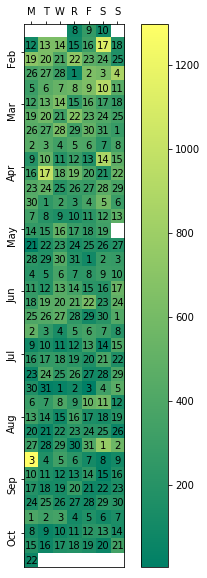

In [64]:
# HEAT MAP OF TEXT MESSAGES SENT 
fig, ax = plt.subplots(figsize=(6, 10))
calendar_heatmap(ax, days, np.asarray(list(n_texts.values())))
plt.show()

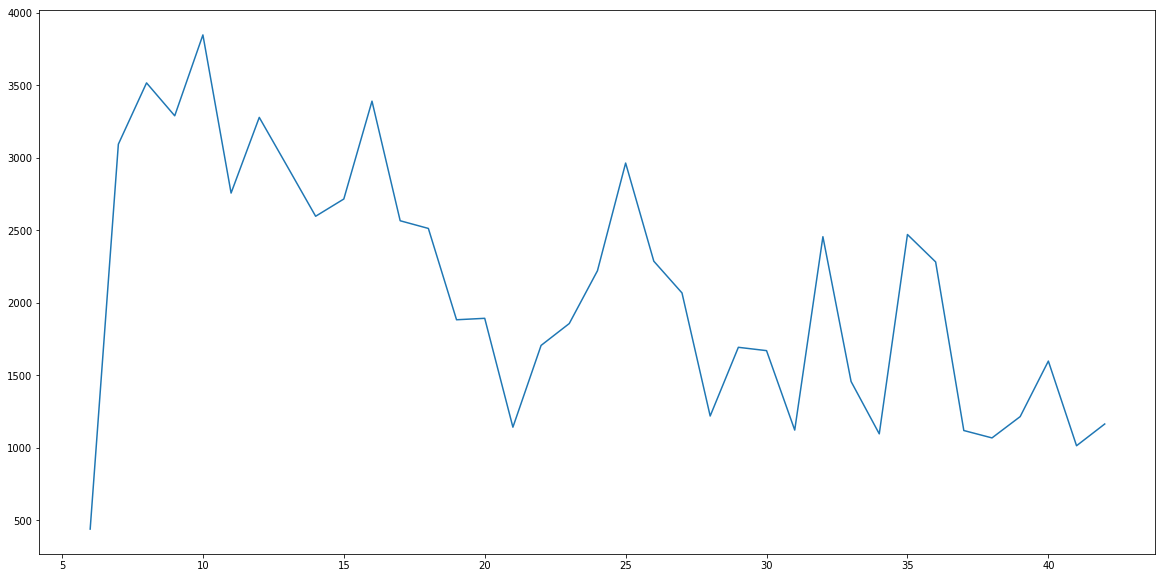

In [85]:
# PLOT OF NUMBER OF CHANGE OF NUMBER OF TEXT MESSAGES
plt.figure(figsize=(20,10))
plt.plot(weekly_change.keys(), weekly_change.values())

In [66]:
def contains_word(word):
    return df[df['text'].str.contains(word)]

In [107]:
# RETURNS DF OF TEXTS CONTAINING CERTAIN WORD
word_search = contains_word("novi")
word_search.head()

datetime  is_from_me  \
date       time                                                   
2018-03-23 23:48:00+00:00 2018-03-23 23:48:00+00:00           1   
2018-04-17 00:43:00+00:00 2018-04-17 00:43:00+00:00           0   
2018-05-05 01:47:00+00:00 2018-05-05 01:47:00+00:00           1   
           12:15:00+00:00 2018-05-05 12:15:00+00:00           1   
2018-05-13 09:15:00+00:00 2018-05-13 09:15:00+00:00           1   

                                              text  word_count   link  media  \
date       time                                                                
2018-03-23 23:48:00+00:00         gracias mi novia         3.0  False  False   
2018-04-17 00:43:00+00:00  and then i get a novio          6.0  False  False   
2018-05-05 01:47:00+00:00           adios mi novia         3.0  False  False   
           12:15:00+00:00                mi novia          2.0  False  False   
2018-05-13 09:15:00+00:00         tu novio es aquí         4.0  False  False   

                           weekday  week        date            time  hour  \
date       time                                                              
2018-03-23 23:48:00+00:00        4    12  2018-03-23  23:48:00+00:00    23   
2018-04-17 00:43:00+00:00        1    16  2018-04-17  00:43:00+00:00     0   
2018-05-05 01:47:00+00:00        5    18  2018-05-05  01:47:00+00:00     1   
           12:15:00+00:00        5    18  2018-05-05  12:15:00+00:00    12   
2018-05-13 09:15:00+00:00        6    19  2018-05-13  09:15:00+00:00     9   

                                                                      tokens  
date       time                                                               
2018-03-23 23:48:00+00:00           [(gracias, NNS), (mi, VBP), (novia, NN)]  
2018-04-17 00:43:00+00:00  [(and, CC), (then, RB), (i, VB), (get, VBP), (...  
2018-05-05 01:47:00+00:00             [(adios, NNS), (mi, VBP), (novia, NN)]  
           12:15:00+00:00                            [(mi, NN), (novia, NN)]  
2018-05-13 09:15:00+00:00      [(tu, NN), (novio, CC), (es, NN), (aquí, NN)]

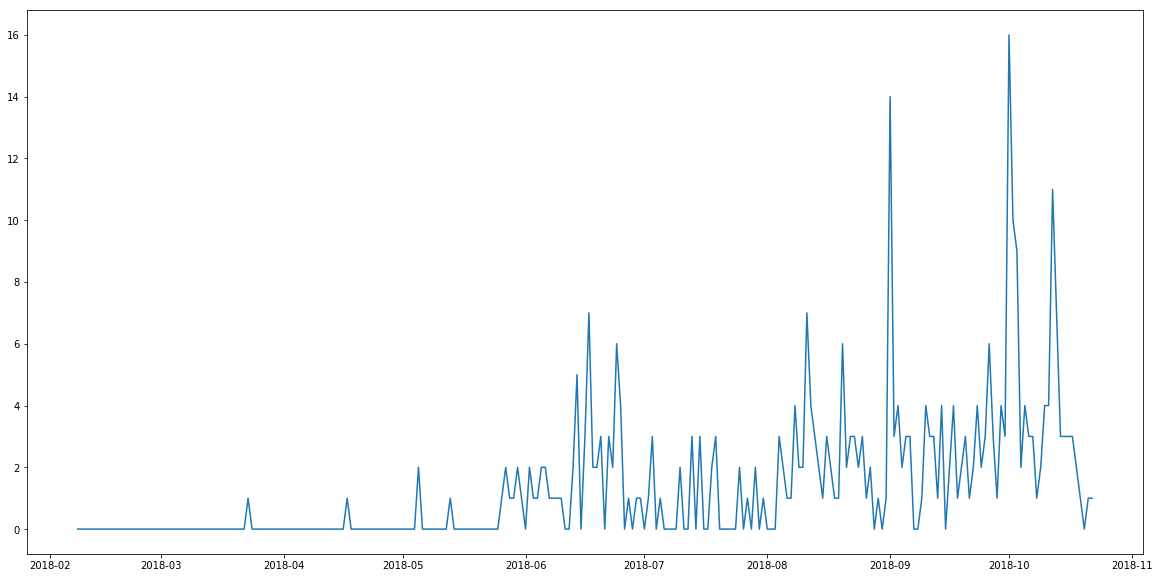

In [108]:
# 
word_search_count = count_texts(word_search, days)
plt.figure(figsize=(20,10))
plt.plot(word_search_count.keys(), word_search_count.values())

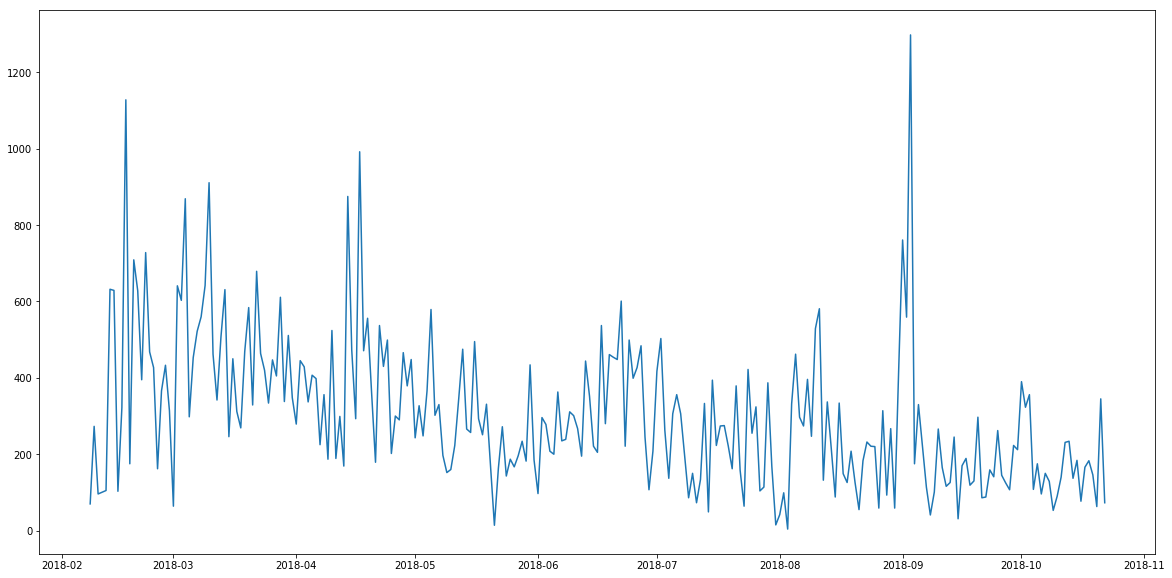

In [97]:
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(n_texts.keys(), n_texts.values())